# TODO:
## mesure curvature
## vehicle distance to the center
##

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

###  Computing Camera Matrix

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Undistort Images

undistort uisng global variables
--- 0.01129603385925293 seconds ---
undistort from scratch
--- 0.777299165725708 seconds ---


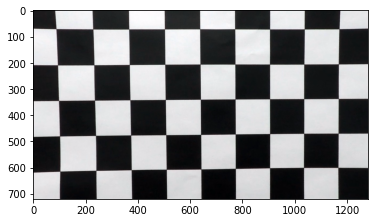

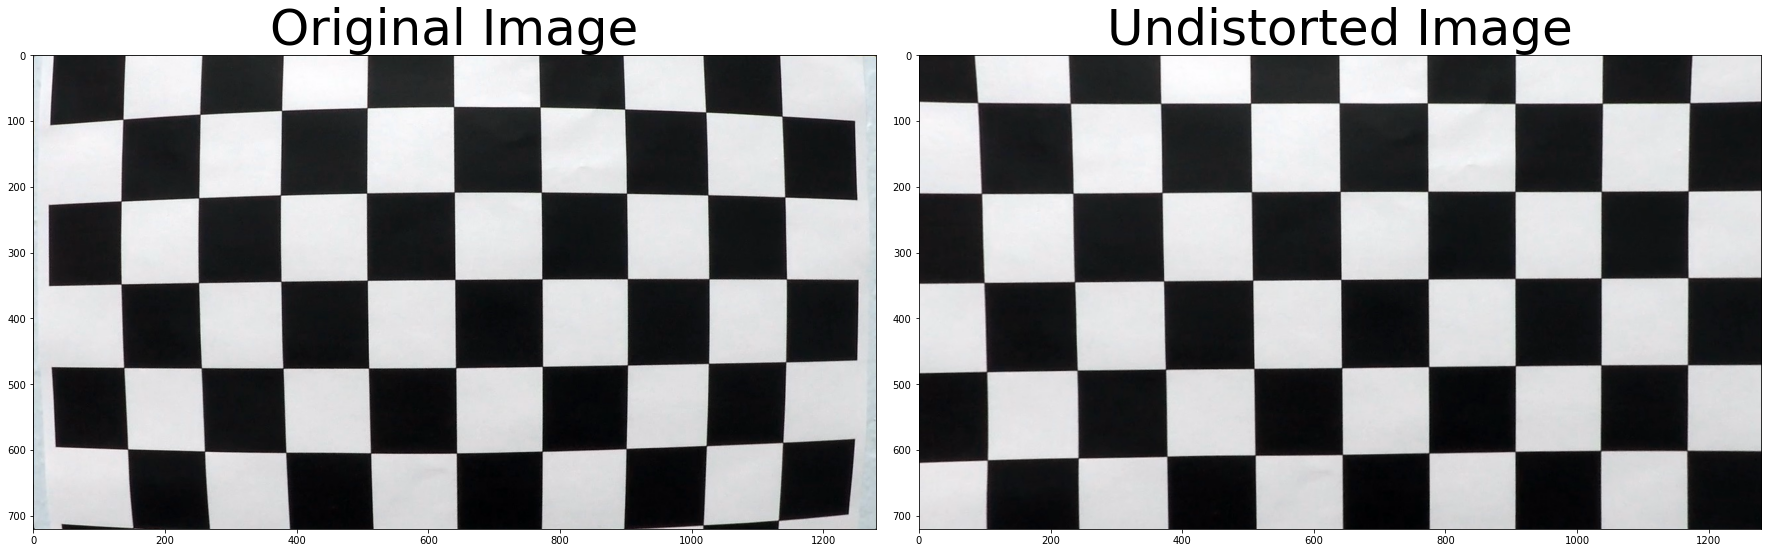

In [3]:
import time
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
shape = gray.shape[::-1]
# TODO: Save extracted matrix and use it for calibrating the camera
# this way the calculation of the distortion matrix needs to be done only 1 time

# this function extracts camera matrix
def cal_distortion_params(objpoints, imgpoints, shape):
    # camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    # return camera matrix
    # undist = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist
# Extract camera matrix
mtx, dist = cal_distortion_params(objpoints, imgpoints, shape)

# this function uses precalculated camera matrix 
def undistort_image(img):
    # use global variables
    global mtx, dist
    # calculate undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


print("undistort uisng global variables")
start_time = time.time()  # checking performance
image_undistorted = undistort_image(img)
print("--- %s seconds ---" % (time.time() - start_time))

plt.imshow(image_undistorted)

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # Transform image to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # calculate undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

print("undistort from scratch")
start_time = time.time()  # checking performance
undistorted = cal_undistort(img, objpoints, imgpoints)
print("--- %s seconds ---" % (time.time() - start_time))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Using Thresholding
Combining color and gradient thresholds for lane detection

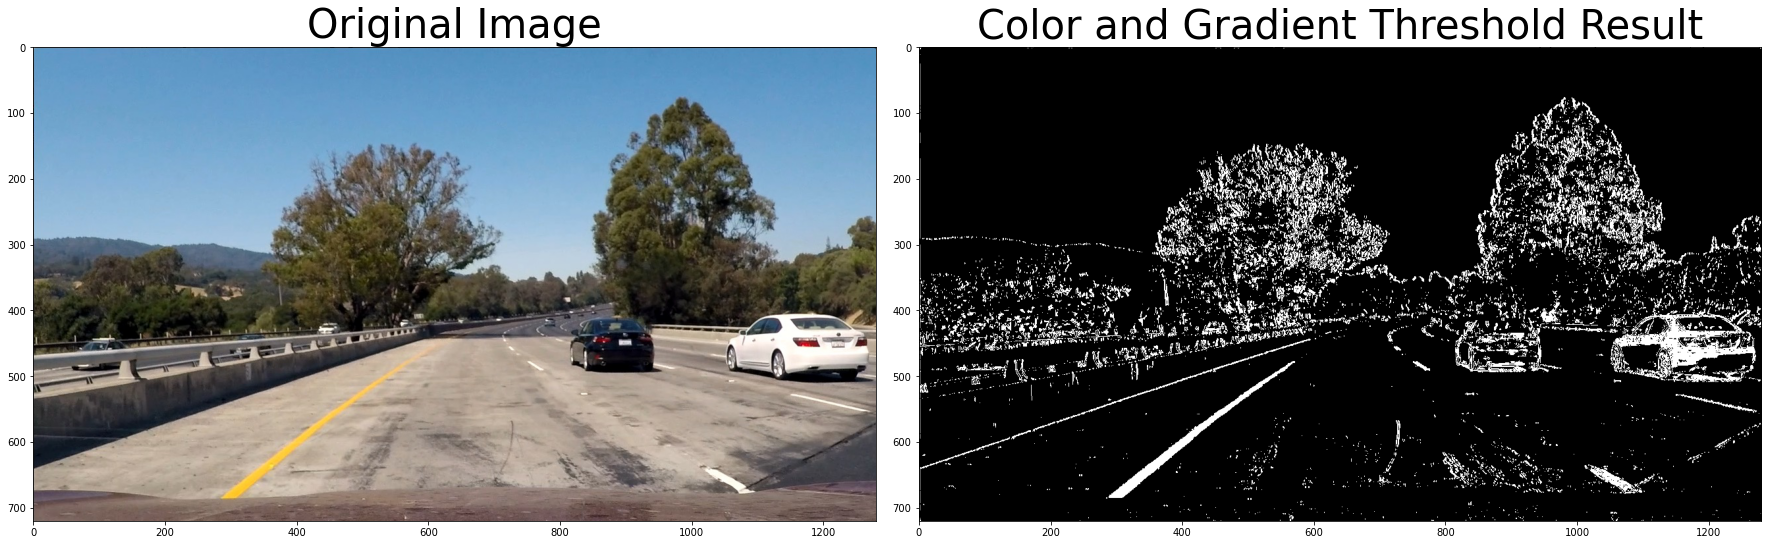

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


image = mpimg.imread('test_images/test1.jpg')

# this pipeline detects lane lines using color and gradient thresholding.
def color_grad_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
threshold_image = color_grad_threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(threshold_image, cmap='gray')
ax2.set_title('Color and Gradient Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [60]:
%matplotlib qt
image = mpimg.imread('test_images/straight_lines2.jpg')
plt.imshow(image)

## Perspective Transform 

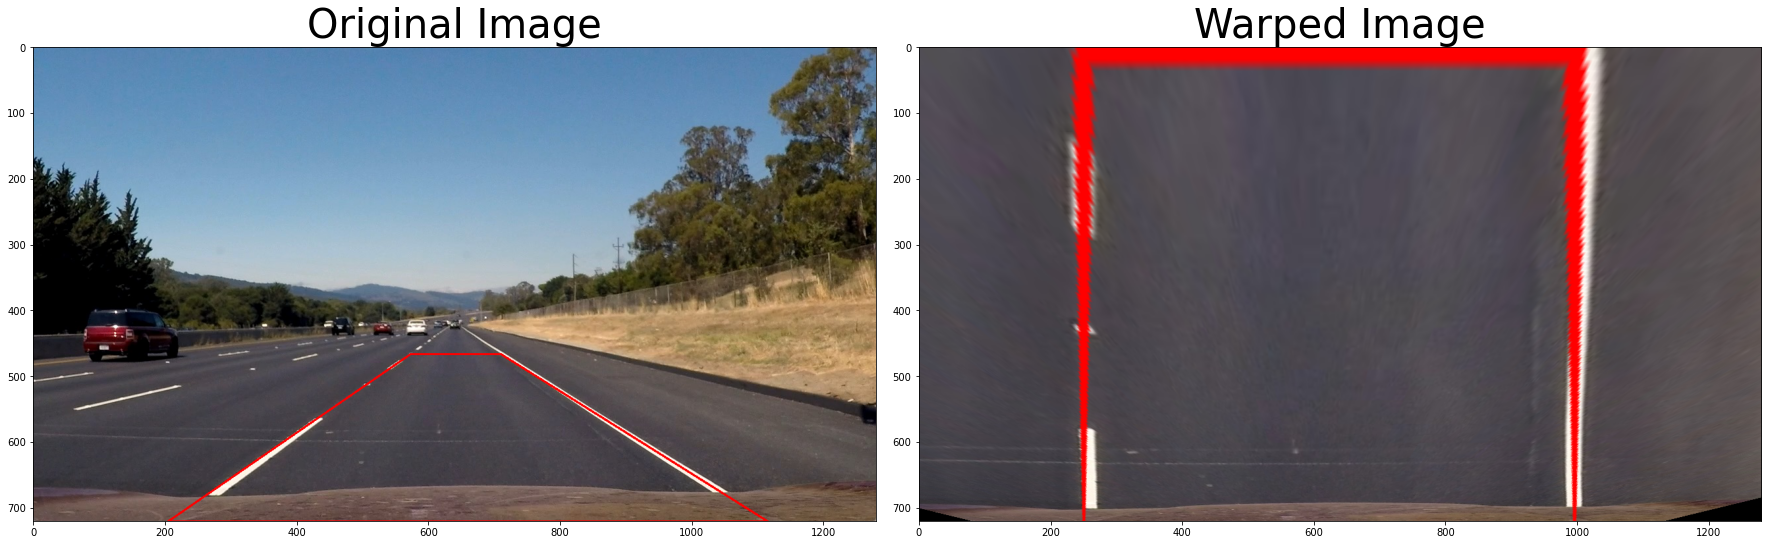

In [67]:
%matplotlib inline

# color in RGB for drawing trapezoid
color = (255,0,0)  # red
# thickness
thickness = 2
# specify corners 
top_left = (573, 466)
top_right = (710, 466)
bottom_right = (1115, 720) #(1043, 674) 
bottom_left = (205, 720) #(280, 674) 
# define 4 source points for the perspective transform
src = np.float32([list(top_left),list(top_right),list(bottom_left),list(bottom_right)])
#src = np.float32([[250,0],[950,0],[250,720],[950,720]])

# define 4 destination points for the perspective transform
dst = np.float32([[250,0],[995,0],[250,720],[995,720]])
#dst = np.float32([[100,0],[1180,0],[100,720],[1180,720]])  # more "fullscreen"
# calculate transformation matrix
M_transformation = cv2.getPerspectiveTransform(src, dst)
Minv_transformation = cv2.getPerspectiveTransform(dst, src)
# image size needed for warping 
img_size = (img.shape[1], img.shape[0])

# function for perspective warping
def warp_perspective(image):
    global M_transformation, img_size
    warped = cv2.warpPerspective(image, M_transformation, img_size, flags=cv2.INTER_LINEAR)
    return warped

# Try for image with straight linesp
image = mpimg.imread('test_images/straight_lines2.jpg')
cv2.line(image, bottom_left, top_left, color, thickness)
cv2.line(image, top_left, top_right, color, thickness) 
cv2.line(image, top_right, bottom_right, color, thickness) 
cv2.line(image, bottom_right, bottom_left, color, thickness) 
warped = warp_perspective(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Warp Threshold image
warped_image = warp_perspective(threshold_image)
#plt.imshow(warped_image, cmap='gray')

## Detecting Lane Lines: 
using sliding window algorithm to detect line pixels

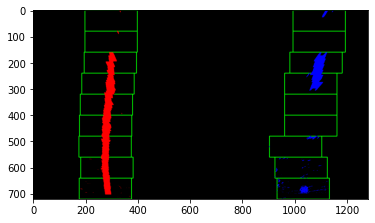

In [68]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # TODO: if less then 0
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# this function fits a ploynomial for the detected pixels
def fit_polynomial(binary_warped, ym_per_pix=30/720, xm_per_pix=3.7/910):
    '''
    Calculates lane line points and fits a second order polynomial 
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit a second order plynomial using real measures
    left_fit_cr = np.polyfit(lefty  * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Plots the left and right polynomials on the lane lines
    #print(np.int32(left_fitx))
    #print(type(ploty))
    #plt.plot(left_fitx, ploty, color='yellow')
    #out_img[np.int32(ploty), np.int32(left_fitx)] = [0, 255, 255]
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr

# test on example image
out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(warped_image)
plt.imshow(out_img)

## Measure Curvature 

In [69]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr, xm_per_pix=3.7/910, ym_per_pix =30/720):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) * ym_per_pix

    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power(1 + np.square(2 * left_fit_cr[0] * y_eval + left_fit_cr[1]), 3/2) / np.abs( 2 * left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = np.power(1 + np.square(2 * right_fit_cr[0] * y_eval + right_fit_cr[1]), 3/2) / np.abs( 2 * right_fit_cr[0])  ## Implement the calculation of the right line here
    
    
    return left_curverad, right_curverad

# Pipeline

1697.6319550634141 m 1159.309985906349 m


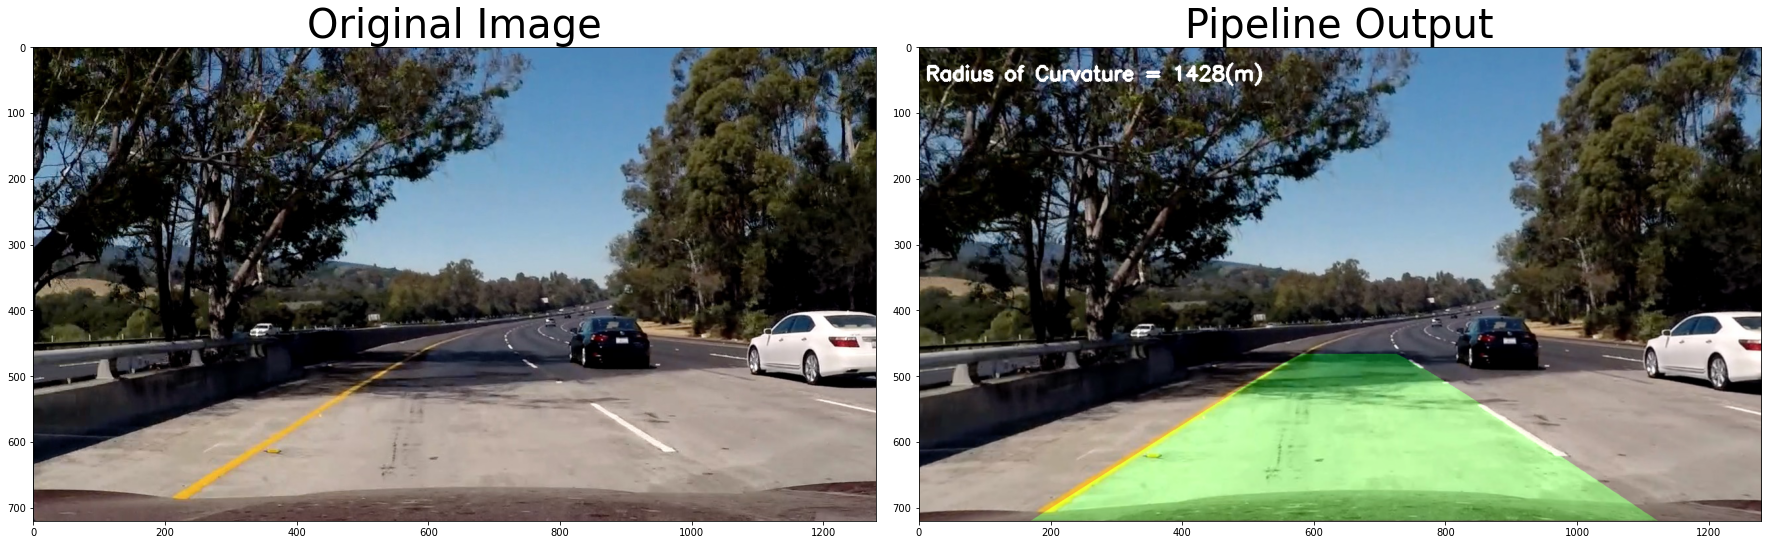

In [80]:
def pipeline(image):
    # distortion correction
    undsitorted_img= undistort_image(image)
    # color and gradient threshold
    threshold_image = color_grad_threshold(image)
    # Perspective transform
    warped_image = warp_perspective(threshold_image) 
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/910 # meters per pixel in x dimension
    
    # Detect Lane Lines: use sliding window algorithm
    out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(warped_image)
    
    # Calculate curvature
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr, 
                                                           xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    print(left_curverad, 'm', right_curverad, 'm')

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv_transformation, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undsitorted_img, 1, newwarp, 0.3, 0)
    # Print curvature value
    curvatur_text = "Radius of Curvature = " + str(int((left_curverad + right_curverad) // 2)) + "(m)"  
    position = (10,50)
    cv2.putText(result, curvatur_text, position, cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255, 255), 3) 
    return result


# test image
image = mpimg.imread('test_images/test5.jpg')
# aply lane line detection
result = pipeline(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Output', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test Pipeline for video

In [81]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'output_videos/challenge_video.mp4' # harder_challenge_video.mp4' #
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5) #("harder_challenge_video.mp4").subclip(5,10) #
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False,)

t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]

3633.9421679135003 m 665.6815963690258 m
Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4

3633.9421679135003 m 665.6815963690258 m



t:   3%|▎         | 4/150 [00:00<00:12, 11.95it/s, now=None]

72255.41990044685 m 586.4445112934037 m
1302.1537205802836 m 533.1964667154099 m



t:   4%|▍         | 6/150 [00:00<00:18,  7.69it/s, now=None]

576.1672791592888 m 524.5157773316826 m
842.5798375858208 m 497.23979546215173 m



t:   5%|▌         | 8/150 [00:00<00:19,  7.27it/s, now=None]

806.2509240042824 m 495.93970309577514 m
359.8129603201725 m 449.7493071252669 m



t:   6%|▌         | 9/150 [00:01<00:21,  6.66it/s, now=None]

733.3421265844868 m 490.2712916184855 m
544.7357477301856 m 559.3314101400078 m



t:   8%|▊         | 12/150 [00:01<00:23,  5.98it/s, now=None]

450.80661252472544 m 537.8927060144317 m
1015.1985113411095 m 561.9239871921608 m



t:   9%|▉         | 14/150 [00:01<00:21,  6.32it/s, now=None]

935.1418385008709 m 495.24345725341726 m
836.3119418768409 m 564.3236703834096 m



t:  11%|█         | 16/150 [00:02<00:21,  6.36it/s, now=None]

1424.1093032268216 m 575.2347975089062 m
710.4084142107484 m 691.1273629756554 m



t:  11%|█▏        | 17/150 [00:02<00:21,  6.33it/s, now=None]

788.8758164002379 m 748.542075878986 m



t:  12%|█▏        | 18/150 [00:02<00:23,  5.57it/s, now=None]

627.588874057311 m 748.5345000471029 m
375.3781171232169 m 545.7860412409079 m



t:  14%|█▍        | 21/150 [00:03<00:20,  6.44it/s, now=None]

300.7338226034933 m 492.9505283405894 m
264.9807524005359 m 409.6360155019326 m



t:  15%|█▌        | 23/150 [00:03<00:20,  6.25it/s, now=None]

295.927722520216 m 323.15552045228645 m
761.8496542301718 m 457.85183346785817 m



t:  17%|█▋        | 25/150 [00:03<00:19,  6.36it/s, now=None]

301.38676694071194 m 502.293802000307 m
251.95061728924424 m 334.9424836338691 m



t:  18%|█▊        | 27/150 [00:04<00:19,  6.17it/s, now=None]

241.41211190916027 m 310.54886545461125 m
306.7501607939559 m 299.11102153262334 m



t:  19%|█▉        | 29/150 [00:04<00:19,  6.25it/s, now=None]

259.48121239783785 m 314.7854421190555 m
297.1686026788365 m 421.6347497951222 m



t:  21%|██        | 31/150 [00:04<00:18,  6.27it/s, now=None]

285.29549456832905 m 346.28734513621686 m
251.2869071688509 m 416.5098086362618 m



t:  22%|██▏       | 33/150 [00:05<00:18,  6.25it/s, now=None]

290.8265973078592 m 396.4303045164646 m
362.00581886613475 m 377.2043289907526 m



t:  23%|██▎       | 35/150 [00:05<00:17,  6.43it/s, now=None]

534.3139107911069 m 393.7435269580725 m
462.9758160571894 m 433.53963338948995 m



t:  24%|██▍       | 36/150 [00:05<00:16,  6.98it/s, now=None]

447.8589924411673 m 443.8461417086013 m
306.9574109850485 m 381.3475651884363 m



t:  26%|██▌       | 39/150 [00:06<00:17,  6.30it/s, now=None]

280.63651976191954 m 353.3678161670226 m
323.16645625621584 m 413.97469755781583 m



t:  27%|██▋       | 41/150 [00:06<00:15,  6.84it/s, now=None]

281.26353453935707 m 479.94308848849965 m
233.29449453696407 m 489.9706027267977 m



t:  28%|██▊       | 42/150 [00:06<00:15,  7.15it/s, now=None]


227.2728339081805 m 564.7195701091315 m
141.0697911707221 m 617.2560281942872 m


t:  30%|███       | 45/150 [00:06<00:16,  6.34it/s, now=None]

137.0452431866698 m 547.1159430873453 m
133.0693557415637 m 309.4418258356656 m



t:  31%|███▏      | 47/150 [00:07<00:16,  6.32it/s, now=None]

139.7489225223528 m 303.4426452383698 m
138.8917052613473 m 346.75353383028835 m



t:  33%|███▎      | 49/150 [00:07<00:16,  6.31it/s, now=None]

141.71519311121142 m 521.0520706305424 m
824.6383973645771 m 567.2093892968204 m



t:  34%|███▍      | 51/150 [00:07<00:14,  6.86it/s, now=None]

155.6134366304713 m 488.2060964809459 m
142.69631868332587 m 471.87043058870717 m



t:  35%|███▌      | 53/150 [00:08<00:13,  7.15it/s, now=None]

151.8149527679045 m 466.81251474345527 m
156.82793927235303 m 467.6693781911915 m



t:  37%|███▋      | 55/150 [00:08<00:14,  6.78it/s, now=None]

171.21903665465027 m 471.2509315910199 m
187.85870264030984 m 486.84921044781385 m



t:  37%|███▋      | 56/150 [00:08<00:14,  6.60it/s, now=None]

209.84093582198304 m 506.75337204480724 m
203.03599078535657 m 493.4741291096093 m



t:  39%|███▉      | 59/150 [00:09<00:14,  6.25it/s, now=None]

201.32966061695544 m 468.73045315194486 m
206.52090910874364 m 310.7014752981863 m



t:  40%|████      | 60/150 [00:09<00:15,  5.76it/s, now=None]

231.48832552496526 m 326.5114833665002 m



t:  41%|████      | 61/150 [00:09<00:17,  5.21it/s, now=None]

213.43021867099236 m 333.4507428317653 m
216.794520390229 m 654.5265130717943 m



t:  43%|████▎     | 64/150 [00:09<00:14,  6.05it/s, now=None]

213.13862637009774 m 644.7263453799222 m
227.0330034675392 m 611.5276351625054 m



t:  43%|████▎     | 65/150 [00:10<00:14,  5.79it/s, now=None]

236.932104496459 m 501.9106869508329 m
255.5189868515016 m 550.4643005900277 m



t:  45%|████▌     | 68/150 [00:10<00:14,  5.51it/s, now=None]

308.06019956699504 m 481.7336041931774 m
343.9610106421054 m 475.47324428724374 m



t:  47%|████▋     | 70/150 [00:11<00:13,  5.98it/s, now=None]

441.8047880882094 m 582.1410882994595 m
254.75980690336644 m 711.9713720450754 m



t:  48%|████▊     | 72/150 [00:11<00:13,  5.80it/s, now=None]

409.34697450908743 m 568.8944756699816 m
434.1407696107946 m 1203.14265317395 m



t:  49%|████▉     | 74/150 [00:11<00:11,  6.61it/s, now=None]

474.8927451661924 m 664.0238123477739 m
509.01446042764417 m 1268.1758641389167 m



t:  51%|█████     | 76/150 [00:11<00:11,  6.70it/s, now=None]

458.0677835408087 m 705.325884476629 m
381.8829862173961 m 612.7283700967001 m



t:  52%|█████▏    | 78/150 [00:12<00:10,  6.88it/s, now=None]

393.52229019911636 m 703.2592832757168 m
429.8245860662451 m 812.7702209712388 m



t:  53%|█████▎    | 80/150 [00:12<00:11,  6.34it/s, now=None]

506.6383645375222 m 726.5286876179887 m
520.048239542961 m 777.759506066233 m



t:  55%|█████▍    | 82/150 [00:12<00:09,  6.90it/s, now=None]

556.2288693339641 m 809.311113012918 m
651.7622942074871 m 684.2662552924503 m



t:  56%|█████▌    | 84/150 [00:13<00:09,  6.61it/s, now=None]

668.1401697836944 m 768.3438744121437 m
909.5843462838242 m 867.9292440914198 m



t:  57%|█████▋    | 86/150 [00:13<00:10,  6.34it/s, now=None]

860.9582522476975 m 542.4254475436899 m
829.4124502831664 m 431.35307737174315 m



t:  59%|█████▊    | 88/150 [00:13<00:09,  6.43it/s, now=None]

659.7465891191231 m 330.6073354117761 m
640.4443099511077 m 677.3636263090804 m



t:  59%|█████▉    | 89/150 [00:13<00:09,  6.18it/s, now=None]


703.7964610504483 m 158.6537040456213 m
524.7077613605926 m 393.2365728765487 m


t:  61%|██████▏   | 92/150 [00:14<00:09,  6.41it/s, now=None]

548.5489045896999 m 448.60014943983975 m
459.57085114361496 m 689.1512595786799 m



t:  63%|██████▎   | 94/150 [00:14<00:08,  6.33it/s, now=None]

580.5178388259205 m 981.6796225421405 m
539.1321292226702 m 2386.8238074039577 m



t:  64%|██████▍   | 96/150 [00:15<00:08,  6.31it/s, now=None]

507.60971672024004 m 2192.0424939963477 m
463.52647575619727 m 519.4765026539629 m



t:  65%|██████▍   | 97/150 [00:15<00:09,  5.73it/s, now=None]

356.5506675687934 m 500.09699453623745 m
289.89419508418194 m 467.24869381355654 m



t:  67%|██████▋   | 100/150 [00:15<00:08,  5.85it/s, now=None]

274.6810801929837 m 465.2810286626248 m
228.39145330345733 m 439.4834418626814 m



t:  68%|██████▊   | 102/150 [00:16<00:07,  6.11it/s, now=None]

241.13614665074562 m 472.64773939853944 m
255.39980107235203 m 505.3540308098917 m



t:  69%|██████▉   | 104/150 [00:16<00:07,  5.82it/s, now=None]

212.79553082356205 m 549.9572616416559 m
199.9993676880731 m 542.9447940632007 m



t:  71%|███████   | 106/150 [00:16<00:07,  5.93it/s, now=None]

213.54219447084793 m 549.3551316627713 m
213.33822256315565 m 451.72205361738423 m



t:  72%|███████▏  | 108/150 [00:17<00:06,  6.61it/s, now=None]

218.295352395354 m 429.8556194556984 m
214.00434051128164 m 424.20628879139514 m



t:  73%|███████▎  | 110/150 [00:17<00:06,  6.38it/s, now=None]

180.99611342868704 m 561.9977860676852 m
144.33143324456003 m 557.6703114994654 m



t:  74%|███████▍  | 111/150 [00:17<00:05,  6.54it/s, now=None]

135.46366376142524 m 335.06837118924733 m
117.63851535133276 m 310.444408978464 m



t:  76%|███████▌  | 114/150 [00:18<00:05,  6.66it/s, now=None]

104.01395597221503 m 298.1117952044651 m
102.72934346692043 m 326.92870280819227 m



t:  77%|███████▋  | 116/150 [00:18<00:05,  6.48it/s, now=None]

105.30956482139626 m 356.4001065640577 m
100.2570855724207 m 432.1525005083727 m



t:  79%|███████▊  | 118/150 [00:18<00:05,  6.30it/s, now=None]

96.7629810909223 m 413.89423746281506 m
73.11513799557957 m 435.67322698207687 m



t:  80%|████████  | 120/150 [00:19<00:04,  6.29it/s, now=None]

74.58857162788254 m 368.77804485663887 m
70.57904764178501 m 241.1683065295694 m



t:  82%|████████▏ | 123/150 [00:19<00:03,  7.75it/s, now=None]

68.92323551272044 m 99.44343048405362 m
78.58853688560937 m 634.8879484330485 m
877.4995528021847 m 1014.9461807587523 m



t:  83%|████████▎ | 125/150 [00:19<00:02,  8.68it/s, now=None]

84.76156815670623 m 791.2769197766926 m
77.26188535705485 m 706.7342124143387 m
833.247256048093 m 528.2475637101678 m



t:  86%|████████▌ | 129/150 [00:19<00:02, 10.02it/s, now=None]

203.34288550133746 m 401.8412513856518 m
133.96194103991888 m 450.91323178015676 m
66.1882670636241 m 418.37420290884904 m



t:  87%|████████▋ | 131/150 [00:19<00:01, 10.62it/s, now=None]

1183.7329192335428 m 558.3997641568317 m
1191.9081430173128 m 864.128300178213 m
1257.3976082040867 m 519.7487333833717 m



t:  90%|█████████ | 135/150 [00:20<00:01, 11.38it/s, now=None]

1465.4723193466311 m 477.5958471430887 m
2.5479819787608213 m 1088.6432576847692 m
19.62977244082156 m 801.0880408925 m



t:  91%|█████████▏| 137/150 [00:20<00:01, 10.86it/s, now=None]

10.282754502672995 m 421.53530136892124 m
890.8347159906248 m 541.0625705086724 m



t:  93%|█████████▎| 139/150 [00:20<00:01,  9.21it/s, now=None]

5.046811829603014 m 662.1704350438673 m
30.3569086738792 m 912.186601123921 m



t:  94%|█████████▍| 141/150 [00:21<00:01,  8.71it/s, now=None]

14.953359908532176 m 946.9038688588331 m
2.822634276525134 m 744.8518375476434 m



t:  95%|█████████▌| 143/150 [00:21<00:00,  7.97it/s, now=None]

4.31068757657932 m 726.6958107091331 m
222.042104449636 m 351.2445173653252 m



t:  97%|█████████▋| 145/150 [00:21<00:00,  7.95it/s, now=None]

225.77092144987935 m 388.0488563435968 m
310.67149500871284 m 336.11485222970214 m



t:  98%|█████████▊| 147/150 [00:21<00:00,  8.08it/s, now=None]

274.71606153717715 m 381.96179026459095 m
383.8890532705904 m 441.8057858126372 m



t:  99%|█████████▉| 149/150 [00:22<00:00,  7.51it/s, now=None]

868.7540724160414 m 598.8576905433133 m
3073.147508902724 m 688.9127843615815 m



t: 100%|██████████| 150/150 [00:22<00:00,  6.75it/s, now=None]
                                                              

2506.4406559883937 m 683.0912418324315 m
784.8249094149381 m 670.3016666178261 m


t:  22%|██▏       | 33/150 [3:32:25<00:17,  6.52it/s, now=None]

Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
CPU times: user 2min 22s, sys: 4.6 s, total: 2min 27s
Wall time: 23.7 s


In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def pipeline(self, image):
        # distortion correction
        undsitorted_img= undistort_image(image)
        # color and gradient threshold
        threshold_image = color_grad_threshold(image)
        # Perspective transform
        warped_image = warp_perspective(threshold_image) 
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Detect Lane Lines: use sliding window algorithm
        out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr = fit_polynomial(warped_image)

        # Calculate curvature
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_cr, right_fit_cr, 
                                                               xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
        print(left_curverad, 'm', right_curverad, 'm')

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv_transformation, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undsitorted_img, 1, newwarp, 0.3, 0)
        return result

# define 2 instances for left and right line


NameError: name 'left_line' is not defined